In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import pycountry
import numpy as np
import seaborn as sns


In [2]:
pd.set_option('display.max_columns', 70)
pd.set_option('display.max_rows', 90)
df = pd.read_csv('/Users/ogizelenovic/Downloads/MASTER.csv')
df.rename(columns={'SH/M ': 'SH/M', 'SH ': 'SH', 'CS ': 'CS'}, inplace=True)

In [3]:
#sns plotting style

sns.set_style("darkgrid")
sns.set_palette("viridis")

colours = {
    'scatter_point': "#BED3F9",
    'trend_line': "#9F5757", 
    'title_color': 'white',
    'label_color': "#FFFFFF" 
}

plt.rcParams.update({
    'axes.facecolor': '#2B2B2B',
    'figure.facecolor': '#1E1E1E', 
    'axes.edgecolor': colours['label_color'],
    'xtick.color': colours['label_color'],
    'ytick.color': colours['label_color'],
    'axes.labelcolor': colours['label_color'],
    'axes.titlecolor': colours['title_color'],
    'axes.titlesize': 15,
    'axes.labelsize': 12,
    'legend.facecolor': '#2B2B2B',
    'legend.edgecolor': 'none',
    'text.color': colours['title_color'],
    'grid.alpha': 0.3
})

In [4]:
codes = [
    'fr FRA', 'eng ENG', 'no NOR', 'br BRA', 'es ESP', 'de GER',
    'ua UKR', 'be BEL', 'pl POL', 'jp JPN', 'it ITA', 'gh GHA',
    'pt POR', 'nl NED', 'eg EGY', 'ee EST', 'wls WAL', 'sct SCO',
    'ar ARG', 'jm JAM', 'se SWE', 'co COL', 'bf BFA', 'au AUS',
    'hu HUN', 'dk DEN', 'ie IRL', 'tr TUR', 'ro ROU', 'us USA',
    'ci CIV', 'cd COD', 'cm CMR', 'ng NGA', 'ir IRN', 'gd GRN',
    'al ALB', 'kr KOR', 'is ISL', 'ec ECU', 'py PAR', 'tn TUN',
    'ch SUI', 'za RSA', 'tg TOG', 'xk KVX', 'ma MAR', 'ao ANG',
    'cl CHI', 'sn SEN', 'rs SRB', 'fi FIN', 'ml MLI', 'gw GNB',
    'ae UAE', 'mx MEX', 'sk SVK', 'ca CAN', 'nz NZL', 'uy URU',
    'nir NIR', 'gr GRE', 'zw ZIM', 'hr CRO', '0', 'cr CRC', 'ba BIH',
    'dz ALG', 'lt LTU', 'il ISR', 'cz CZE', 'ga GAB', 'at AUT',
    'id IDN', 'lr LBR', 'zm ZAM', 've VEN', 'do DOM', 'gn GUI',
    'iq IRQ', 'ms MSR', 'me MNE', 'cw CUW', 'bd BAN', 'sl SLE',
    'mr MTN', 'bg BUL', 'mk MKD', 'th THA', 'kn SKN', 'am ARM',
    'tz TAN', 'cu CUB', 'ke KEN', 'ph PHI', 'gt GUA', 'cn CHN',
    'bj BEN', 'si SVN', 'gq EQG'
]

def get_country_name(code):
    try:
        # Special cases for non-standard codes:
        special_cases = {
            'eng': 'England',
            'wls': 'Wales',
            'sct': 'Scotland',
            'nir': 'Northern Ireland',
            'xk': 'Kosovo',
            '0': 'Unknown'
        }
        if code.lower() in special_cases:
            return special_cases[code.lower()]
        
        # For normal ISO alpha-2 codes
        country = pycountry.countries.get(alpha_2=code.upper())
        if country:
            return country.name
        
        # If not found, try alpha_3
        country = pycountry.countries.get(alpha_3=code.upper())
        if country:
            return country.name
        
        return 'Unknown'
    except Exception:
        return 'Unknown'

result = {}
for entry in codes:
    parts = entry.split()
    if len(parts) == 0 or entry == '0':
        result[entry] = 'Unknown'
        continue
    # Take the first part (2-letter or special code)
    code = parts[0]
    country_name = get_country_name(code)
    result[entry] = country_name

df['Nation'] = df['Nation'].map(result)


In [5]:
country_grp = df.groupby(['Squad', 'Season'])

In [6]:
rank = df.groupby(['Season', 'Squad'])['Rk'].mean()

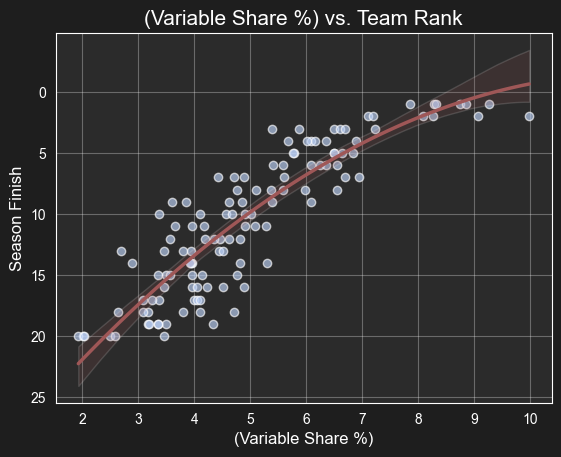

In [13]:
def create_plot_feature_vs_rank(df, feature, rank):
    #summing for all teams, then unstacking to get season as rows (pivot table)
    var = country_grp[feature].sum()
    var = var.unstack(level='Squad')

    #summing total goals for each team per season, then unstacking as well to match no_total
    total_var = df.groupby(['Squad', 'Season'])
    total_vars = total_var[feature].sum()
    team_vars_byseason = total_vars.unstack(level='Season')
    totalvars = team_vars_byseason.sum()
    totalvars_df=totalvars.to_frame(name='Total (Variable)')

    var['Total (Variable)'] = totalvars_df
    #dataframe without the total ...
    no_total = var.drop('Total (Variable)', axis=1)

    #turnign the values into percentages
    percentages = no_total.div(totalvars, axis ='index')
    percentages = percentages * 100
    percentages = percentages.fillna(0)

    #melting
    var_axis = percentages.stack()
    var_axis = var_axis.to_frame(name='Total (Variable)')

    #creating new colum 'Rank'
    var_axis['Rank'] = rank

    #plot scatter
    sns.regplot(
    data=df, 
    x=var_axis['Total (Variable)'], 
    y=var_axis['Rank'],
    ci=95,
    order=2,
    scatter_kws={
        'alpha': 0.65, 
        'color': colours['scatter_point'],
        'edgecolor': 'w',
    },
    line_kws={
        'color': colours['trend_line'],
        'linewidth': 2.5
    }
    )

    plt.title('(Variable Share %) vs. Team Rank')
    plt.xlabel('(Variable Share %)')
    plt.ylabel('Season Finish')
    plt.gca().invert_yaxis()

feature= 'Gls'
test = create_plot_feature_vs_rank(df, feature, rank)

In [ ]:
sns.regplot(
    data=df, 
    x=var_axis['Total (Variable)'], 
    y=var_axis['Rank'],
    ci=95,
    order=2,
    scatter_kws={
        'alpha': 0.65, 
        'color': colours['scatter_point'],
        'edgecolor': 'w',
    },
    line_kws={
        'color': colours['trend_line'],
        'linewidth': 2.5
    }
    )